# Simulating the Ball Being Thrown

In [11]:
import numpy as np
from IPython.display import HTML, SVG, display
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys
import pydot

from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.systems.planar_scenegraph_visualizer import ConnectPlanarSceneGraphVisualizer
from pydrake.systems.primitives import LogVectorOutput, WrapToSystem
from pydrake.all import (
    StartMeshcat, 
    MeshcatVisualizer, 
    MeshcatVisualizerParams,
    InverseDynamicsController
)

from pydrake.solvers import MathematicalProgram, Solve, OsqpSolver

In [12]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7005


## Ball Simulation in 2D

In [13]:
def ball_sim(time, initial_state, log=False, visualize=False, graph=False, meshcat=None, control=None,
            accuracy=1e-4, min_step=0, step_target=None, fixed_step=False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
    parser = Parser(plant)
    parser.AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))

    plant.Finalize()

    n_pos = plant.num_positions()
    print(n_pos)

    if log:
        logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    if meshcat:
        vis_params = MeshcatVisualizerParams(publish_period=0.01)
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)
    if visualize:
        T_VW = np.array([[1., 0., 0., 0.],
                         [0., 0., 1., 0.],
                         [0., 0., 0., 1.]])
        visualizer = ConnectPlanarSceneGraphVisualizer(
            builder, scene_graph, T_VW=T_VW, xlim=[-2, 2],
            ylim=[-2, 2], show=False)
        visualizer.start_recording()


    diagram = builder.Build()
    if graph:
        display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    context = diagram.CreateDefaultContext()
    simulator = Simulator(diagram, context)
    simulator.get_integrator().set_target_accuracy(accuracy)
    if step_target is not None:
        simulator.get_integrator().request_initial_step_size_target(step_target)
    simulator.get_integrator().set_requested_minimum_step_size(min_step)
    simulator.get_integrator().set_fixed_step_mode(fixed_step)
    simulator.Initialize()
    if not control:
        plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
        plant.get_actuation_input_port().FixValue(plant_context, np.zeros(plant.num_actuators()))
    if meshcat:
        simulator.set_target_realtime_rate(1)
    #context.SetContinuousState(initial_state)

    for t in tqdm(np.linspace(0, time, 100), file=sys.stdout):
        simulator.AdvanceTo(t)

    if log:
        log = logger.FindLog(context)
        time = log.sample_times()[1:]
        data = log.data()[:,1:]
    if visualize:
        visualizer.stop_recording()
        ani = HTML(visualizer.get_recording_as_animation().to_jshtml())
    if log and visualize:
        return time, data, ani
    if log:
        return time, data
    if visualize:
        return ani

7


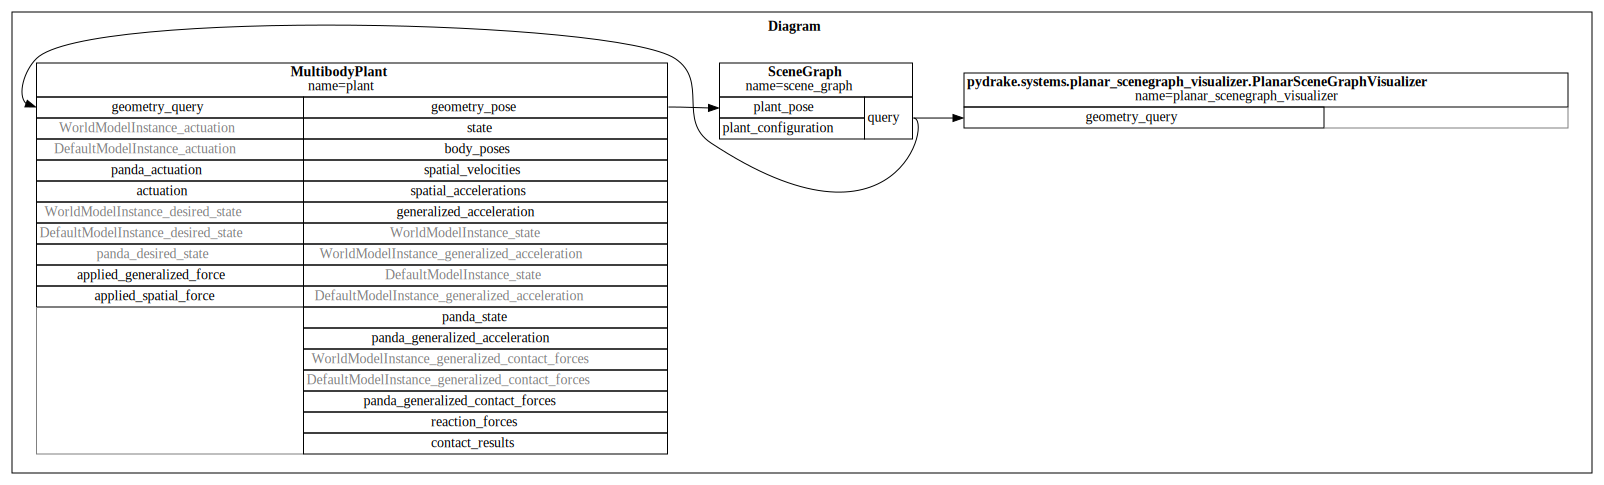

100%|██████████| 100/100 [00:00<00:00, 1981.98it/s]


In [19]:
ball_sim(1, np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), visualize=True, graph=True)

# 4 -> orientation
# 3 -> position
# 3 -> angular vel
# 3 -> linear vel

In [15]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
# panda_model = Parser(plant, scene_graph).AddModelsFromUrl(
#     "package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf"
# )[0]
panda_model = Parser(plant=plant).AddModels("./panda_arm_custom.urdf")[0]

plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
panda_controller = builder.AddSystem(
    InverseDynamicsController(plant, kp, ki, kd, False)
)
panda_controller.set_name("panda_controller")
builder.Connect(
    plant.get_state_output_port(panda_model),
    panda_controller.get_input_port_estimated_state(),
)
builder.Connect(
    panda_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with panda controller")

In [16]:
'''
This function computes the MPC controller input u
'''

# Parameters for the QP
N = 1000
dt = 0.1

# Initialize mathematical program and decalre decision variables
prog = MathematicalProgram()
x = np.zeros((N, 6), dtype="object")
for i in range(N):
  x[i] = prog.NewContinuousVariables(6, "x_" + str(i))

q = np.zeros((N, 3), dtype="object")
for i in range(N):
  q[i] = prog.NewContinuousVariables(3, "q_" + str(i))

v = np.zeros((N, 3), dtype="object")
for i in range(N):
  v[i] = prog.NewContinuousVariables(3, "v_" + str(i))

t_catch = np.zeros(1, dtype="object")
t_catch = prog.NewContinuousVariables(1, "t_" + str(i))[0]

# u = np.zeros((N-1, 2), dtype="object")
# for i in range(N-1):
#   u[i] = prog.NewContinuousVariables(7, "u_" + str(i))

q0 = np.array([2, 3, 4])
v0 = np.array([1, 1, 0])

# Add constraints and cost

prog.AddBoundingBoxConstraint(q0, q0, q[0])
prog.AddBoundingBoxConstraint(v0, v0, v[0])
prog.AddBoundingBoxConstraint(1, np.inf, t_catch)

for i in range(N-1):
    q_next = q[i] +  v[i] * dt - q[i+1] 
    prog.AddLinearEqualityConstraint(q_next, np.zeros(3))
    prog.AddBoundingBoxConstraint(np.ones(3)*-1, np.ones(3), v[i])
    
g = 9.81

q0_ball = np.array([0.5, 0.5, 0])
v0_ball = np.array([1, 1, 0])

x_final = q0_ball[0] + v0_ball[0] * t_catch
y_final = q0_ball[1] + v0_ball[1] * t_catch
z_final = q0_ball[2] + v0_ball[2] * t_catch - 0.5 * g * t_catch**2

q_final = [x_final, y_final, z_final] - q[N-1]

print(q_final[0])
print(q_final[1])
print(q_final[2])
    
# prog.AddLinearEqualityConstraint(q_final, np.zeros(3))
prog.AddConstraint(q_final[0] == 0)
prog.AddConstraint(q_final[1] == 0)
prog.AddConstraint(q_final[2] == 0)

prog.AddQuadraticCost(dt**2)

# self.add_initial_state_constraint(prog, x, x_current)
# self.add_input_saturation_constraint(prog, x, u, N)
# self.add_dynamics_constraint(prog, x, u, N, T)
# self.add_cost(prog, x, u, N)

# print(prog)

# Placeholder constraint and cost to satisfy QP requirements
# TODO: Delete after completing this function
# prog.AddQuadraticCost(0)
# prog.AddLinearEqualityConstraint(0, 0)

# Solve the QP
# solver = OsqpSolver()
result = Solve(prog)

print(result.GetSolution(t_catch))
print(result.GetSolution(q))
print(result.GetSolution(v))
print("success = ", result.is_success())

# u_mpc = np.zeros(2)
# TODO: retrieve the controller input from the solution of the optimization problem
# and use it to compute the MPC input u
# You should make use of result.GetSolution(decision_var) where decision_var
# is the variable you want
# u_mpc = result.GetSolution(u)[0] + self.u_d()

(0.5 - q_999(0) + t_999(0))
(0.5 - q_999(1) + t_999(0))
( - q_999(2) - 4.9050000000000002 * pow(t_999(0), 2))
1.0
[[ 2.     3.     4.   ]
 [ 2.1    3.1    4.   ]
 [ 2.     3.     3.9  ]
 ...
 [ 1.5    1.5   -4.905]
 [ 1.5    1.5   -4.905]
 [ 1.5    1.5   -4.905]]
[[ 1.  1.  0.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 ...
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
success =  True


In [17]:
# simulator = Simulator(diagram, context)
# simulator.set_target_realtime_rate(1.0)
# simulator.AdvanceTo(5.0 if True else 0.1);

## Ball Simulation in 3D

In [18]:
ball_sim(1, np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]), meshcat=meshcat)

7
100%|██████████| 100/100 [00:00<00:00, 106.62it/s]
